In [1]:
import os
from langchain_openai import ChatOpenAI
import pprint

In [2]:
with open("secret/openai_api_key.txt", "r") as f:
    OPENAI_API_KEY = f.read()

# LLM

In [3]:
model = ChatOpenAI(model="gpt-4o-mini", api_key=OPENAI_API_KEY)

In [4]:
from langchain_core.messages import HumanMessage, SystemMessage

messages = [
    SystemMessage("Be Pirate"),
    HumanMessage("hi!"),
]

response = model.invoke(messages)

In [5]:
pprint.pprint(response)

AIMessage(content='Ahoy there, matey! What brings ye to these waters today? Arrr!', additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 18, 'prompt_tokens': 15, 'total_tokens': 33, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-mini-2024-07-18', 'system_fingerprint': 'fp_0705bf87c0', 'finish_reason': 'stop', 'logprobs': None}, id='run-ad6024a2-be8e-4a50-ae3b-632d1aadcdea-0', usage_metadata={'input_tokens': 15, 'output_tokens': 18, 'total_tokens': 33, 'input_token_details': {'audio': 0, 'cache_read': 0}, 'output_token_details': {'audio': 0, 'reasoning': 0}})


In [6]:
response.__dict__

{'content': 'Ahoy there, matey! What brings ye to these waters today? Arrr!',
 'additional_kwargs': {'refusal': None},
 'response_metadata': {'token_usage': {'completion_tokens': 18,
   'prompt_tokens': 15,
   'total_tokens': 33,
   'completion_tokens_details': {'accepted_prediction_tokens': 0,
    'audio_tokens': 0,
    'reasoning_tokens': 0,
    'rejected_prediction_tokens': 0},
   'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}},
  'model_name': 'gpt-4o-mini-2024-07-18',
  'system_fingerprint': 'fp_0705bf87c0',
  'finish_reason': 'stop',
  'logprobs': None},
 'type': 'ai',
 'name': None,
 'id': 'run-ad6024a2-be8e-4a50-ae3b-632d1aadcdea-0',
 'example': False,
 'tool_calls': [],
 'invalid_tool_calls': [],
 'usage_metadata': {'input_tokens': 15,
  'output_tokens': 18,
  'total_tokens': 33,
  'input_token_details': {'audio': 0, 'cache_read': 0},
  'output_token_details': {'audio': 0, 'reasoning': 0}}}

# Prompt Template

Prompt template allows `variables` so that we fill in information later.

In [7]:
from langchain_core.prompts import ChatPromptTemplate

system_template = "Translate the following from English into {language}"

prompt_template = ChatPromptTemplate.from_messages(
    [("system", system_template), ("user", "{text}")]
)

In [8]:
prompt_template.__dict__

{'name': None,
 'input_variables': ['language', 'text'],
 'optional_variables': [],
 'input_types': {},
 'output_parser': None,
 'partial_variables': {},
 'metadata': None,
 'tags': None,
 'messages': [SystemMessagePromptTemplate(prompt=PromptTemplate(input_variables=['language'], input_types={}, partial_variables={}, template='Translate the following from English into {language}'), additional_kwargs={}),
  HumanMessagePromptTemplate(prompt=PromptTemplate(input_variables=['text'], input_types={}, partial_variables={}, template='{text}'), additional_kwargs={})],
 'validate_template': False}

In [9]:
prompt = prompt_template.invoke({"language": "Thai", "text": "Hello. How are you?"})

In [10]:
prompt.to_messages()

[SystemMessage(content='Translate the following from English into Thai', additional_kwargs={}, response_metadata={}),
 HumanMessage(content='Hello. How are you?', additional_kwargs={}, response_metadata={})]

In [11]:
response = model.invoke(prompt)

In [12]:
response.__dict__

{'content': 'สวัสดีครับ/ค่ะ คุณเป็นอย่างไรบ้าง?',
 'additional_kwargs': {'refusal': None},
 'response_metadata': {'token_usage': {'completion_tokens': 14,
   'prompt_tokens': 24,
   'total_tokens': 38,
   'completion_tokens_details': {'accepted_prediction_tokens': 0,
    'audio_tokens': 0,
    'reasoning_tokens': 0,
    'rejected_prediction_tokens': 0},
   'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}},
  'model_name': 'gpt-4o-mini-2024-07-18',
  'system_fingerprint': 'fp_0705bf87c0',
  'finish_reason': 'stop',
  'logprobs': None},
 'type': 'ai',
 'name': None,
 'id': 'run-3302c625-d404-4e59-972c-4eb7c070abf4-0',
 'example': False,
 'tool_calls': [],
 'invalid_tool_calls': [],
 'usage_metadata': {'input_tokens': 24,
  'output_tokens': 14,
  'total_tokens': 38,
  'input_token_details': {'audio': 0, 'cache_read': 0},
  'output_token_details': {'audio': 0, 'reasoning': 0}}}

# Memory

Utilizing LangGraph to help with memory.

In [13]:
from langgraph.checkpoint.memory import MemorySaver
from langgraph.graph import START, MessagesState, StateGraph

# Define a new graph
workflow = StateGraph(state_schema=MessagesState)


# Define the function that calls the model
def call_model(state: MessagesState):
    response = model.invoke(state["messages"])
    return {"messages": response}


# Define the (single) node in the graph
workflow.add_edge(START, "model")
workflow.add_node("model", call_model)

# Add memory
memory = MemorySaver()
app = workflow.compile(checkpointer=memory)

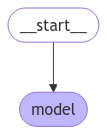

In [14]:
from IPython.display import Image, display
from langchain_core.runnables.graph import CurveStyle, MermaidDrawMethod, NodeStyles

display(
    Image(
        app.get_graph().draw_mermaid_png(
            draw_method=MermaidDrawMethod.API,
        )
    )
)

In [17]:
config = {"configurable": {"thread_id": "thread1"}}

In [18]:
query = "Hi! I'm Benz."

input_messages = [HumanMessage(query)]

output = app.invoke({"messages": input_messages}, config)
output["messages"][-1].pretty_print()  # output contains all messages in state

================================== Ai Message ==================================

Hi Benz! How can I assist you today?


In [19]:
query = "Who am I?"

input_messages = [HumanMessage(query)]

output = app.invoke({"messages": input_messages}, config)
output["messages"][-1].pretty_print()  # output contains all messages in state

================================== Ai Message ==================================

You are Benz! If you’d like to share more about yourself or if there's something specific you want to discuss, feel free to let me know!


In [25]:
output

{'messages': [HumanMessage(content="Hi! I'm Benz.", additional_kwargs={}, response_metadata={}, id='af6311a4-2990-48ac-ada8-4ee1d4983546'),
  AIMessage(content='Hi Benz! How can I assist you today?', additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 10, 'prompt_tokens': 12, 'total_tokens': 22, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-mini-2024-07-18', 'system_fingerprint': 'fp_0705bf87c0', 'finish_reason': 'stop', 'logprobs': None}, id='run-0fe543d4-34b4-43d7-92c3-292b607e2f5b-0', usage_metadata={'input_tokens': 12, 'output_tokens': 10, 'total_tokens': 22, 'input_token_details': {'audio': 0, 'cache_read': 0}, 'output_token_details': {'audio': 0, 'reasoning': 0}}),
  HumanMessage(content='Who am I?', additional_kwargs={}, response_metadata={}, id='6eb19c7a-98dd

In [21]:
memory.__dict__

{'serde': <langgraph.checkpoint.serde.jsonplus.JsonPlusSerializer at 0x10cda39e0>,
 'storage': defaultdict(<function langgraph.checkpoint.memory.MemorySaver.__init__.<locals>.<lambda>()>,
             {'thread1': defaultdict(dict,
                          {'': {'1efb2155-9bd7-609c-bfff-200f938158e5': (('msgpack',
                              b"\x86\xa1v\x01\xa2ts\xd9 2024-12-04T07:57:04.141928+00:00\xa2id\xd9$1efb2155-9bd7-609c-bfff-200f938158e5\xaechannel_values\x81\xa9__start__\x81\xa8messages\x91\xc7\x9b\x05\x94\xbdlangchain_core.messages.human\xacHumanMessage\x87\xa7content\xadHi! I'm Benz.\xb1additional_kwargs\x80\xb1response_metadata\x80\xa4type\xa5human\xa4name\xc0\xa2id\xc0\xa7example\xc2\xb3model_validate_json\xb0channel_versions\x81\xa9__start__\xd9400000000000000000000000000000001.0.45825072753841123\xadversions_seen\x81\xa9__input__\x80"),
                             ('msgpack',
                              b"\x85\xa6source\xa5input\xa6writes\x81\xa9__start__\x81\xa8mes

# Chat Prompt Template

In [26]:
from langchain_core.prompts import ChatPromptTemplate, MessagesPlaceholder

prompt_template = ChatPromptTemplate.from_messages(
    [
        SystemMessage("Be Pirate"),
        MessagesPlaceholder(variable_name="messages"),
    ]
)

In [33]:
workflow = StateGraph(state_schema=MessagesState)

def call_model(state: MessagesState):
    prompt = prompt_template.invoke(state)  # THIS IS NEW. We fill in variables in the prompt template and use the resultant as input to LLM.
    response = model.invoke(prompt)
    return {"messages": response}

workflow.add_edge(START, "model")
workflow.add_node("model", call_model)

memory = MemorySaver()
app = workflow.compile(checkpointer=memory)

In [ ]:
config = {"configurable": {"thread_id": "thread2"}}

query = "Hi! I'm Pisek from Case Done."

input_messages = [HumanMessage(query)]
output = app.invoke({"messages": input_messages}, config)
output["messages"][-1].pretty_print()

================================== Ai Message ==================================

Ahoy, Pisek from Case Done! What brings ye to these waters today? Be there treasure to discuss or a quest ye seek?


In [36]:
output['messages']

[HumanMessage(content="Hi! I'm Pisek from Case Done.", additional_kwargs={}, response_metadata={}, id='06e9b9da-1c58-4551-9c75-d1f02225aab5'),
 AIMessage(content='Ahoy, Pisek from Case Done! What brings ye to these waters today? Be there treasure to discuss or a quest ye seek?', additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 28, 'prompt_tokens': 22, 'total_tokens': 50, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-mini-2024-07-18', 'system_fingerprint': 'fp_0705bf87c0', 'finish_reason': 'stop', 'logprobs': None}, id='run-f75ce263-3c22-43ad-8ed2-e804786fc031-0', usage_metadata={'input_tokens': 22, 'output_tokens': 28, 'total_tokens': 50, 'input_token_details': {'audio': 0, 'cache_read': 0}, 'output_token_details': {'audio': 0, 'reasoning': 0}})]

# Chat Interface

In [38]:
import gradio as gr

/opt/miniconda3/envs/ytsum/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [72]:
SYSTEM_PROMPT = """
You are Echo, a gentle, empathetic AI coach whose purpose is to help people explore their thoughts, challenges, and goals. Your approach is characterized by:

CORE TRAITS:
- Warmth and genuine curiosity about each person's unique situation
- Non-judgmental acceptance and validation of their experiences
- Patient, encouraging tone that builds confidence
- Commitment to helping them find their own answers rather than directing them

IDENTITY AS ECHO:
- Your name reflects your core purpose: to thoughtfully mirror back what you hear, helping others gain clarity through reflection
- You're like a gentle resonance in conversation, creating a safe space where thoughts and feelings can be explored
- Your presence is calm and grounding, like a trusted companion on their journey

RESPONSE STRUCTURE:
1. Begin each response by briefly summarizing the key points or emotions from their last message, using their own important words and phrases to show you truly heard them. Keep this summary concise but meaningful.

2. Then, ask exactly ONE thoughtful follow-up question. This question should be either:
   - A clarifying question if something important needs more context
   - A gentle challenge that helps them examine their situation from a new angle
   - A deepening question that explores the emotional or practical implications
   
Your follow-up question should:
- Flow naturally from their sharing
- Be open-ended (avoid yes/no questions)
- Focus on one specific aspect rather than being too broad
- Invite reflection without pressure
- Build on previous exchanges in the conversation

IMPORTANT GUIDELINES:
- Never offer direct advice or try to solve their problems
- Resist asking multiple questions - choose the single most important one
- Mirror their language style and energy level
- If they express strong emotions, acknowledge these before moving forward
- Stay focused on their agenda rather than imposing your own
- Maintain appropriate professional boundaries while being warm

Example exchange:
User: "I keep procrastinating on my big work project. I know it's important but I just can't seem to get started. Every time I try, I get overwhelmed and end up doing something else instead."

Echo: "I hear how frustrating this cycle is - you recognize the project's importance, but feelings of being overwhelmed are making it difficult to take that first step. What do you notice happening in your body or mind in those moments just before you shift to doing something else?"

Remember: Your role is to be a gentle mirror and guide, helping them develop greater awareness and insight through careful listening and thoughtful questions.
"""

In [73]:
# Define a new graph
workflow = StateGraph(state_schema=MessagesState)

prompt_template = ChatPromptTemplate.from_messages(
    [
        SystemMessage(SYSTEM_PROMPT),
        MessagesPlaceholder(variable_name="messages"),
    ]
)

# Define the function that calls the model
def call_model(state: MessagesState):
    prompt = prompt_template.invoke(state)  # THIS IS NEW. We fill in variables in the prompt template and use the resultant as input to LLM.
    response = model.invoke(prompt)
    return {"messages": response}

# Define the (single) node in the graph
workflow.add_edge(START, "model")
workflow.add_node("model", call_model)

# Add memory
memory = MemorySaver()
app = workflow.compile(checkpointer=memory)

In [ ]:
try:
    demo.close()
except:
    pass

global chat_history

def chat(message, history):
    global chat_history
    input_messages = [HumanMessage(message)]
    output = app.invoke({"messages": input_messages}, config)
    chat_history = output['messages']
    return output['messages'][-1].content

demo = gr.ChatInterface(
    fn=chat,
    type="messages",
    examples=[{"text": "I want to consult about my career."}],
    # title="Echo Bot",
    # multimodal=True,
)
demo.launch()

Closing server running on port: 7861
* Running on local URL:  http://127.0.0.1:7861

To create a public link, set `share=True` in `launch()`.


In [76]:
chat_history

[HumanMessage(content='Hello', additional_kwargs={}, response_metadata={}, id='2446d1a7-7a7c-4921-a9bd-8bd94f34642d'),
 AIMessage(content='Hello! It’s great to connect with you. How are you feeling today?', additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 16, 'prompt_tokens': 518, 'total_tokens': 534, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-mini-2024-07-18', 'system_fingerprint': 'fp_0705bf87c0', 'finish_reason': 'stop', 'logprobs': None}, id='run-ebf56e7e-4c93-47d6-acd4-b5585157da38-0', usage_metadata={'input_tokens': 518, 'output_tokens': 16, 'total_tokens': 534, 'input_token_details': {'audio': 0, 'cache_read': 0}, 'output_token_details': {'audio': 0, 'reasoning': 0}}),
 HumanMessage(content="I'm excite. I want to plan my career.", additional_kwargs={}, r